In [0]:
%matplotlib inline

import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [6]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
def compute_accuracy(v_xs, v_ys):
    global prediction
    
    y_pre = sess.run(prediction, feed_dict={xs: v_xs, keep_prob: 1})
    # Feeding xs=v_xs and keep_prob=1 to calculate (prediction = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2))
    # where (h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)) >>> that's why we need to feed keep_prob, also (h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1))
    # and (h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64]))...etc, until we reach (xs = tf.placeholder(tf.float32, [None, 784])/255.)
    # and (keep_prob = tf.placeholder(tf.float32)). so basically we are feeding the inputs of the CNN which are v_xs in this case, and feeding
    # the hyperparameter keep_prob as 1 and then forward propagation runs step by step until it predicts the input images' labels.
    
    correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(v_ys,1)) 
    # tf.equal returns the truth value of tf.argmax(y_pre,1) == tf.argmax(v_ys,1) as a tensor of type bool
    # note: tf.argmax returns the index with the largest value across axes of a tensor
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # tf.cast(correct_prediction, tf.float32) casts a tensor to a new type(tf.float32 in this case). Because correct prediction was a tensor of type bool.
    # tf.reduce_mean(...) computes the mean of elements across dimensions of a tensor. note: default value for axis=0, so it returns the mean of each column(one column anyway)
    
    result = sess.run(accuracy, feed_dict={xs: v_xs, ys: v_ys, keep_prob: 1})
    # feeding the test_x and test_y values and the keep_prob hyperparameter to run the model and evaluate the accuracy; 
    # where as mentioned above (accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))
    # also: correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(v_ys,1)) >>> that's why we feed the test_y (v_ys)
    # so the session runs and calculates the accuracy and stores it in the result tensor, which we then return.
    
    return result
  
  
def print_confusion_matrix(v_xs, v_ys):
    # Get the true classifications for the test-set.
    cls_true = np.argmax(v_ys, 1)
    # Get the predicted classifications for the test-set.
    cls_pred = sess.run(prediction, feed_dict={xs: v_xs, keep_prob: 1})
    cls_pred = np.argmax(cls_pred, 1)
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
#     cm = tf.confusion_matrix(labels=cls_true, predictions=cls_pred)
    
    # Print the confusion matrix as text.
    # print(cm)
    # Plot the confusion matrix as an image.
    
    plt.figure(1)
#     plt.subplot(121)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, range(10))
    plt.yticks(tick_marks, range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')

def test(image_no):
    if image_no <= 10000:
        global prediction
        image = np.reshape(mnist.test.images[image_no], [28,28])
        plt.figure(2)
#         plt.subplot(122)
        plt.imshow(image)
        print('\n\nPrediction for test image no {} ='.format(image_no), end=' ')
        print(np.argmax(sess.run(prediction, feed_dict={xs: np.reshape(mnist.test.images[image_no], [1, 28*28]), keep_prob: 1})))
    else:
        print('Image number must be less than 10000')
  
  

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    # another way(done by andrew ng):
#     W = tf.get_variable("W", shape, initializer=tf.contrib.layers.xavier_initializer(seed = 0))  # just using a different initialization method
#     return W
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    # stride [1, x_movement, y_movement, 1]
    # Must have strides[0] = strides[3] = 1
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    # stride [1, x_movement, y_movement, 1]
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


In [0]:

# define placeholder for inputs to network
xs = tf.placeholder(tf.float32, [None, 784])/255.   # 28x28
ys = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)
x_image = tf.reshape(xs, [-1, 28, 28, 1])
# print(x_image.shape)  # [n_samples, 28,28,1]


In [0]:

## conv1 layer ##
W_conv1 = weight_variable([5,5, 1,32]) # patch 5x5, in size 1, out size 32
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) # output size 28x28x32
h_pool1 = max_pool_2x2(h_conv1)                                         # output size 14x14x32


In [0]:

## conv2 layer ##
W_conv2 = weight_variable([5,5, 32, 64]) # patch 5x5, in size 32, out size 64
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) # output size 14x14x64
h_pool2 = max_pool_2x2(h_conv2)                                         # output size 7x7x64


In [0]:

## fc1 layer ##
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
# [n_samples, 7, 7, 64] ->> [n_samples, 7*7*64]
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


In [0]:

## fc2 layer ##
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
prediction = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)


In [0]:

# the error between prediction and real data
cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction),
                                              reduction_indices=[1]))       # loss
train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)


Batch Size = 100 training examples
1 Epoch = 600 batches = the whole 60000 training examples available in the MNIST dataset
Accuracy for 1.0 epoch: 0.9791
Confusion Matrix:


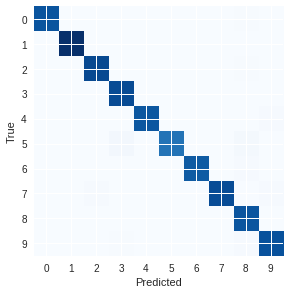

In [32]:

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

print('Batch Size = 100 training examples\n1 Epoch = 600 batches = the whole 60000 training examples available in the MNIST dataset')

num_epochs = 1
for i in range(600 * num_epochs):
    X_batch, Y_batch = mnist.train.next_batch(100)
    #I defined every batch to be of 100 training examples, and since the mnist dataset has 60000 training examples, therefore every 600 batchs define an entire epoch
    sess.run(train_step, feed_dict={xs: X_batch, ys: Y_batch, keep_prob: 0.5})
    if i % 600 == 0 and i != 0:
        # testing on the whole 10000 testing examples available in this dataset
        print('Accuracy for {} epoch:'.format((i / 600)), end=' ')
        print(compute_accuracy(mnist.test.images[:10000], mnist.test.labels[:10000]))
        print('Confusion Matrix:')
        print_confusion_matrix(mnist.test.images[:10000], mnist.test.labels[:10000])
    elif i == (600*num_epochs-1):
        print('Accuracy for {} epoch:'.format(( (i+1) / 600)), end=' ')
        print(compute_accuracy(mnist.test.images[:10000], mnist.test.labels[:10000]))
        print('Confusion Matrix:')
        print_confusion_matrix(mnist.test.images[:10000], mnist.test.labels[:10000])

        
# to show the progress for every 50 batchs instead of the full epochs uncomment this:

# num_epochs = 1
# for i in range(600 * num_epochs):
#     X_batch, Y_batch = mnist.train.next_batch(100)
#     #we define every batch to be of 100 training examples, and since the mnist dataset has 60000 training examples, therefore every 600 batchs define an entire epoch
#     sess.run(train_step, feed_dict={xs: X_batch, ys: Y_batch, keep_prob: 0.5})
#     if i % 50 == 0:
#         print('Accuracy for {} batchs:'.format((i / 50)), end=' ')
#         print(compute_accuracy(mnist.test.images[:10000], mnist.test.labels[:10000]))
#         print('Confusion Matrix:')
#         print_confusion_matrix(mnist.test.images[:10000], mnist.test.labels[:10000])





Prediction for test image no 1285 = 5


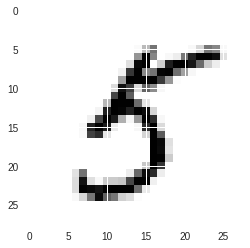

In [60]:
# Testing the images predictions

test_image_no = 1285   #tweak this number to test different images from the test set.
test(test_image_no)